In [2]:
import time
import onnxruntime as ort
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from tqdm.notebook import tqdm

In [3]:
pred_distance = 25
seq_len = 50
model = ort.InferenceSession(f'models/model_{pred_distance}.onnx')

In [4]:
train_data = load_logging_data(data_root_path='data/train')
val_data = load_logging_data(data_root_path='data/val')

train_data['Data_Type'] = 'train'
val_data['Data_Type'] = 'validation'

dataset = pd.concat([train_data, val_data], axis=0)
dataset.reset_index(drop=True, inplace=True)

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]
print(angle_name_list)

pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]
print(pressure_name_list)

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

dataset.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
dataset.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
dataset.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    dataset.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    dataset.rename(columns={pressure_name: new_pressure_name}, inplace=True)

dataset['Work_Load'] = (dataset[new_pressure_name_list[0]] * (dataset['Drill_Rotation(RPM)']))
dataset['Drill_Depth(m)'] = dataset['Drill_Depth(m)']/10

dataset

['angle_Mast_X CH=27', 'angle_Mast_Y CH=28', 'angle_base_X CH=31', 'angle_base_Y CH=32']
['pressure_1_pressure_transmitter_1_drive1 CH=23', 'pressure_1_pressure_transmitter_2_drive2 CH=24', 'pressure_2_pressure_transmitter_6_cyl_1 CH=29', 'pressure_3_pressure_transmitter_7_cyl_2 CH=30']


,Time(sec),BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type,Work_Load
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train,0.0
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0


In [6]:
for angle_name in new_angle_name_list:
    dataset[angle_name] = dataset[angle_name].clip(lower=-3, upper=3)

feature_name_list = new_angle_name_list + [new_pressure_name_list[0], new_pressure_name_list[1]]
#target_name = 'angle_3_diff_det'

target = np.diff(dataset[new_angle_name_list[3]])
target = target >= 0.3
target = np.concatenate([np.zeros(1), target])

feature_arr = dataset[feature_name_list].to_numpy()
dataset_arr = np.concatenate([feature_arr, target.reshape(-1, 1)], axis=1)
print(dataset_arr.shape)

(21374, 7)


In [7]:
n_of_features = len(feature_name_list)
input_buf = np.zeros(shape=(1, seq_len, n_of_features), dtype=np.float32)

est_arr = []
gt_arr = []

for sig_set in tqdm(dataset_arr):
    input_buf = np.roll(a=input_buf, shift=-1, axis=1)
    input_buf[0, -1, :] = sig_set[0:len(feature_name_list)]

    est_flow = np.squeeze(model.run(output_names=None, input_feed={'input': input_buf})).item()
    est_arr.append(est_flow)
    gt_arr.append(sig_set[len(feature_name_list)])

est_arr = np.array(est_arr) > 0.1
est_arr = est_arr.astype(int)
gt_arr = np.array(gt_arr)

  0%|          | 0/21374 [00:00<?, ?it/s]

Text(0, 0.5, 'Differential Angle(deg/sec)')

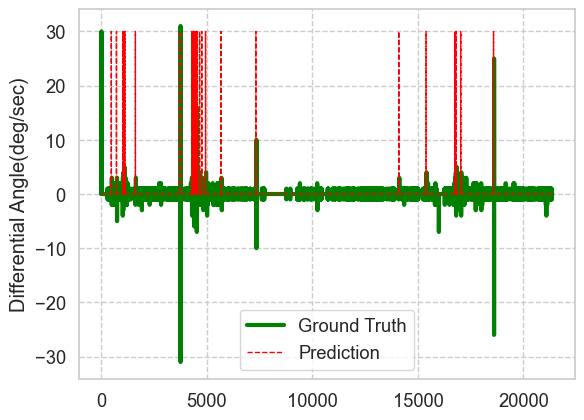

In [54]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

target = np.diff(dataset[new_angle_name_list[3]])
target = np.concatenate([np.zeros(1), target])
target = target*10

sns.lineplot(target, linewidth=3, color='green', label='Ground Truth')
sns.lineplot(est_arr*30, linewidth=1, linestyle='--', color='red', label='Prediction')

#plt.xlim(3500, 4500)
plt.ylabel('Differential Angle(deg/sec)')

In [60]:
a = np.roll(target, shift=-25)

(5000.0, 10000.0)

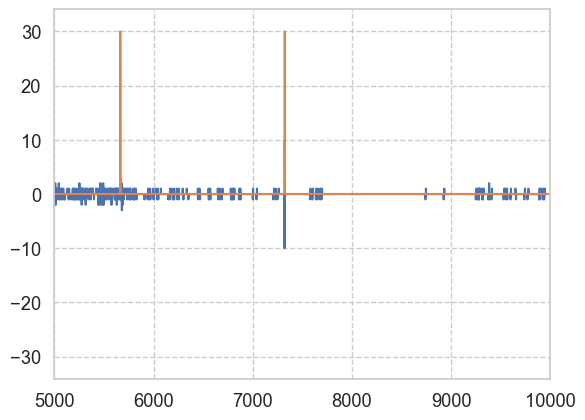

In [62]:
sns.lineplot(a)
sns.lineplot(est_arr*30)

plt.xlim(5000, 10000)

<Axes: >

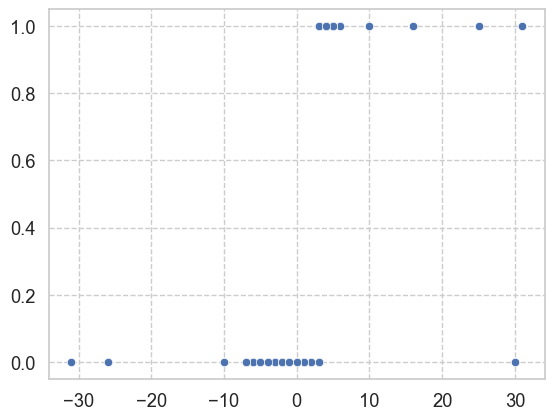

In [63]:
sns.scatterplot(x=a, y=est_arr)